# Voorspellen van de PV productie - % van geïnstalleerd vermogen

In [27]:
# Tested with python 3.9.6

import pickle
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme(color_codes=True)
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scripts import weather_data_preprocess as wdp
from tensorflow.keras.models import Sequential, load_model, save_model
from keras.callbacks import ModelCheckpoint
from keras.layers import Dense, LSTM, Dropout
from prophet import Prophet

## Data-analyse en samenstellen van dataset

! SKIP DIT HOOFDSTUK ALS JE NIET BESCHIKT OVER DE RUWE DATA !

In [28]:
# Ruwe weersdata info
weather_train_data_ingelmunster = [
    'Ingelmunster 2024-01-01 to 2024-01-31.csv',
    'Ingelmunster 2024-02-01 to 2024-02-29.csv',
    'Ingelmunster 2024-03-01 to 2024-03-31.csv',
    'Ingelmunster 2024-04-01 to 2024-04-30.csv',
    'Ingelmunster 2024-05-01 to 2024-05-31.csv',
    'Ingelmunster 2024-06-01 to 2024-06-30.csv',
    'Ingelmunster 2024-07-01 to 2024-07-31.csv',
    'Ingelmunster 2024-08-01 to 2024-08-31.csv',
    'Ingelmunster 2024-09-01 to 2024-09-30.csv',
    'Ingelmunster 2024-10-01 to 2024-10-31.csv',
    'Ingelmunster 2024-11-01 to 2024-11-30.csv',
    'Ingelmunster 2024-12-01 to 2024-12-31.csv',
    'Ingelmunster 2025-01-01 to 2025-01-31.csv',
    'Ingelmunster 2025-02-01 to 2025-02-29.csv',
    'Ingelmunster 2025-03-01 to 2025-03-31.csv',
]
weather_train_data_gullegem = [
    'Gullegem 2024-01-01 to 2024-01-31.csv',
    'Gullegem 2024-02-01 to 2024-02-29.csv',
    'Gullegem 2024-03-01 to 2024-03-31.csv',
    'Gullegem 2024-04-01 to 2024-04-30.csv',
    'Gullegem 2024-05-01 to 2024-05-31.csv',
    'Gullegem 2024-06-01 to 2024-06-30.csv',
    'Gullegem 2024-07-01 to 2024-07-31.csv',
    'Gullegem 2024-08-01 to 2024-08-31.csv',
    'Gullegem 2024-09-01 to 2024-09-30.csv',
    'Gullegem 2024-10-01 to 2024-10-31.csv',
    'Gullegem 2024-11-01 to 2024-11-30.csv',
    'Gullegem 2024-12-01 to 2024-12-31.csv',
    'Gullegem 2025-01-01 to 2025-01-31.csv',
]
weather_test_data_ingelmunster = [
    'Ingelmunster 2025-04-01 to 2025-04-30.csv',
]
ingelmunster_location = [50.920699369528734, 3.2532075343447575]
gullegem_location = [50.8447689, 3.1989718]

In [29]:
# importeren van de ruwe weersdata en deze preprocessen
processor = wdp.WeatherDataPreprocess()
df_weather_ingelmunster = pd.DataFrame(columns=['datetime', 'temp', 'humidity', 'cloudcover', 'solarenergy', 'uvindex', 'latitude', 'longitude', 'solar_azimuth', 'solar_elevation'])
df_weather_gullegem = pd.DataFrame(columns=['datetime', 'temp', 'humidity', 'cloudcover', 'solarenergy', 'uvindex', 'latitude', 'longitude', 'solar_azimuth', 'solar_elevation'])
df_weather_test_ingelmunster = pd.DataFrame(columns=['datetime', 'temp', 'humidity', 'cloudcover', 'solarenergy', 'uvindex', 'latitude', 'longitude', 'solar_azimuth', 'solar_elevation'])
for file in range(len(weather_train_data_ingelmunster)):
    print(f'Processing {weather_train_data_ingelmunster[file]}')
    df_weather_ingelmunster = pd.concat([df_weather_ingelmunster, processor.preprocessWeatherData(lat=ingelmunster_location[0], lng=ingelmunster_location[1], file_name=weather_train_data_ingelmunster[file])])
for file in range(len(weather_test_data_ingelmunster)):
    print(f'Processing {weather_test_data_ingelmunster[file]}')
    df_weather_test_ingelmunster = pd.concat([df_weather_test_ingelmunster, processor.preprocessWeatherData(lat=ingelmunster_location[0], lng=ingelmunster_location[1], file_name=weather_test_data_ingelmunster[file])])
for file in range(len(weather_train_data_gullegem)):
    print(f'Processing {weather_train_data_gullegem[file]}')
    df_weather_gullegem = pd.concat([df_weather_gullegem, processor.preprocessWeatherData(lat=gullegem_location[0], lng=gullegem_location[1], file_name=weather_train_data_gullegem[file])])
df_weather_ingelmunster.head(10)

Processing Ingelmunster 2024-01-01 to 2024-01-31.csv
Processing Ingelmunster 2024-02-01 to 2024-02-29.csv
Processing Ingelmunster 2024-03-01 to 2024-03-31.csv


/var/folders/yg/5hgw5_z931sd5sx564slbskh0000gq/T/ipykernel_59812/2581381214.py:8: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_weather_ingelmunster = pd.concat([df_weather_ingelmunster, processor.preprocessWeatherData(lat=ingelmunster_location[0], lng=ingelmunster_location[1], file_name=weather_train_data_ingelmunster[file])])


Processing Ingelmunster 2024-04-01 to 2024-04-30.csv
Processing Ingelmunster 2024-05-01 to 2024-05-31.csv
Processing Ingelmunster 2024-06-01 to 2024-06-30.csv
Processing Ingelmunster 2024-07-01 to 2024-07-31.csv
Processing Ingelmunster 2024-08-01 to 2024-08-31.csv
Processing Ingelmunster 2024-09-01 to 2024-09-30.csv
Processing Ingelmunster 2024-10-01 to 2024-10-31.csv
Processing Ingelmunster 2024-11-01 to 2024-11-30.csv
Processing Ingelmunster 2024-12-01 to 2024-12-31.csv
Processing Ingelmunster 2025-01-01 to 2025-01-31.csv
Processing Ingelmunster 2025-02-01 to 2025-02-29.csv
File not found at data/raw/Ingelmunster 2025-02-01 to 2025-02-29.csv. Please check the path and try again.
Processing Ingelmunster 2025-03-01 to 2025-03-31.csv
Processing Ingelmunster 2025-04-01 to 2025-04-30.csv
Processing Gullegem 2024-01-01 to 2024-01-31.csv
Processing Gullegem 2024-02-01 to 2024-02-29.csv


/var/folders/yg/5hgw5_z931sd5sx564slbskh0000gq/T/ipykernel_59812/2581381214.py:11: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_weather_test_ingelmunster = pd.concat([df_weather_test_ingelmunster, processor.preprocessWeatherData(lat=ingelmunster_location[0], lng=ingelmunster_location[1], file_name=weather_test_data_ingelmunster[file])])
/var/folders/yg/5hgw5_z931sd5sx564slbskh0000gq/T/ipykernel_59812/2581381214.py:14: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_weather_gullegem = pd.con

Processing Gullegem 2024-03-01 to 2024-03-31.csv
Processing Gullegem 2024-04-01 to 2024-04-30.csv
Processing Gullegem 2024-05-01 to 2024-05-31.csv
Processing Gullegem 2024-06-01 to 2024-06-30.csv
Processing Gullegem 2024-07-01 to 2024-07-31.csv
Processing Gullegem 2024-08-01 to 2024-08-31.csv
Processing Gullegem 2024-09-01 to 2024-09-30.csv
Processing Gullegem 2024-10-01 to 2024-10-31.csv
Processing Gullegem 2024-11-01 to 2024-11-30.csv
Processing Gullegem 2024-12-01 to 2024-12-31.csv
Processing Gullegem 2025-01-01 to 2025-01-31.csv


,datetime,temp,humidity,cloudcover,solarenergy,uvindex,latitude,longitude,solar_azimuth,solar_elevation
0,2024-01-01 00:00:00,7.200,89.080,96.300,0.0,0.0,50.920699,3.253208,-3.058781,-1.083954
1,2024-01-01 00:15:00,7.125,89.600,96.600,0.0,0.0,50.920699,3.253208,-2.931440,-1.077916
2,2024-01-01 00:30:00,7.050,90.120,96.900,0.0,0.0,50.920699,3.253208,-2.807635,-1.066812
3,2024-01-01 00:45:00,6.975,90.640,97.200,0.0,0.0,50.920699,3.253208,-2.689024,-1.050984
4,2024-01-01 01:00:00,6.900,91.160,97.500,0.0,0.0,50.920699,3.253208,-2.576724,-1.030873
5,2024-01-01 01:15:00,7.000,91.195,95.725,0.0,0.0,50.920699,3.253208,-2.471311,-1.006968
6,2024-01-01 01:30:00,7.100,91.230,93.950,0.0,0.0,50.920699,3.253208,-2.372902,-0.979768
7,2024-01-01 01:45:00,7.200,91.265,92.175,0.0,0.0,50.920699,3.253208,-2.281271,-0.949750
8,2024-01-01 02:00:00,7.300,91.300,90.400,0.0,0.0,50.920699,3.253208,-2.195979,-0.917351
9,2024-01-01 02:15:00,7.325,90.540,90.800,0.0,0.0,50.920699,3.253208,-2.116463,-0.882961


In [30]:
# Een checkpoint toevoegen voor de ruwe weersdata
df_weather_ingelmunster.to_csv('data/processed/ingelmunster_weather_data.csv', index=False)
df_weather_gullegem.to_csv('data/processed/gullegem_weather_data.csv', index=False)

In [31]:
# Verwijderen van de kolommen die niet nodig zijn
df_weather_ingelmunster.drop(columns=['humidity', 'latitude', 'longitude'], inplace=True)
df_weather_test_ingelmunster.drop(columns=['humidity', 'latitude', 'longitude'], inplace=True)
df_weather_gullegem.drop(columns=['humidity', 'latitude', 'longitude'], inplace=True)

In [32]:
# Importeren van de ruwe productiedata en deze preprocessen
df_all_jvr = pd.read_csv('data/processed/pv_jvr_total.csv')
df_all_jvr['datetime'] = pd.to_datetime(df_all_jvr['datetime'])
df_all_ddp = pd.read_csv('data/processed/pv_ddp_total.csv')
df_all_ddp['datetime'] = pd.to_datetime(df_all_ddp['datetime'])
# Filter data voor een train en test set. We gebruiken de data van 2024 en de eerste 3 maanden van 2025 voor training, en de data van JVR voor april 2025 voor testen.
df_production_jvr = df_all_jvr[((df_all_jvr['datetime'].dt.year == 2024) | ((df_all_jvr['datetime'].dt.year == 2025) & (df_all_jvr['datetime'].dt.month <= 3)))]
df_production_test_jvr = df_all_jvr[((df_all_jvr['datetime'].dt.year == 2025) & (df_all_jvr['datetime'].dt.month == 4))]
df_production_ddp = df_all_ddp
df_production_jvr.tail(10)

,datetime,total_production_kwh,production_15_min_kwh,production_15_min_%
35579,2025-03-31 21:30:00,21563.814,0.0,0.0
35580,2025-03-31 21:45:00,21563.814,0.0,0.0
35581,2025-03-31 22:00:00,21563.814,0.0,0.0
35582,2025-03-31 22:15:00,21563.814,0.0,0.0
35583,2025-03-31 22:30:00,21563.814,0.0,0.0
35584,2025-03-31 22:45:00,21563.814,0.0,0.0
35585,2025-03-31 23:00:00,21563.814,0.0,0.0
35586,2025-03-31 23:15:00,21563.814,0.0,0.0
35587,2025-03-31 23:30:00,21563.814,0.0,0.0
35588,2025-03-31 23:45:00,21563.814,0.0,0.0


In [33]:
# Voeg de twee dataframes (weersdata en productie) samen
df_jvr = pd.merge(df_production_jvr, df_weather_ingelmunster, on='datetime')
df_jvr.drop(columns=['total_production_kwh', 'production_15_min_kwh'], inplace=True)
df_ddp = pd.merge(df_production_ddp, df_weather_gullegem, on='datetime')
df_ddp.drop(columns=['total_production_kwh', 'production_15_min_kwh'], inplace=True)
df_test_jvr = pd.merge(df_production_test_jvr, df_weather_test_ingelmunster, on='datetime')
df_test_jvr.drop(columns=['total_production_kwh', 'production_15_min_kwh'], inplace=True)
df_jvr.head(10)

,datetime,production_15_min_%,temp,cloudcover,solarenergy,uvindex,solar_azimuth,solar_elevation
0,2024-03-14 08:15:00,0.092,8.325,54.475,0.325,0.5,-1.054120,0.330412
1,2024-03-14 08:45:00,0.387,9.175,46.225,0.575,1.5,-0.935324,0.399732
2,2024-03-14 09:00:00,0.231,9.600,42.100,0.700,2.0,-0.873267,0.432229
3,2024-03-14 09:15:00,0.203,10.000,48.875,0.900,2.5,-0.809274,0.463056
4,2024-03-14 09:30:00,0.172,10.400,55.650,1.100,3.0,-0.743247,0.492032
5,2024-03-14 09:45:00,0.085,10.800,62.425,1.300,3.5,-0.675122,0.518972
6,2024-03-14 12:00:00,4.431,14.800,52.400,2.000,6.0,0.018610,0.640320
7,2024-03-14 12:15:00,0.826,14.925,50.300,1.850,5.5,0.100055,0.637944
8,2024-03-14 12:30:00,0.747,15.050,48.200,1.700,5.0,0.181001,0.632235
9,2024-03-14 12:45:00,0.404,15.175,46.100,1.550,4.5,0.261057,0.623258


In [34]:
# Dataframe controleren - Print de eerste en laatste datetime
print("Eerste datetime:", df_jvr['datetime'].min())
print("Laatste datetime:", df_jvr['datetime'].max())
print("Eerste datetime:", df_ddp['datetime'].min())
print("Laatste datetime:", df_ddp['datetime'].max())

Eerste datetime: 2024-03-14 08:15:00
Laatste datetime: 2025-03-31 23:00:00
Eerste datetime: 2024-03-14 15:45:00
Laatste datetime: 2025-01-31 23:00:00


In [35]:
# Testdataframe controleren - Print de eerste en laatste datetime
print("Eerste datetime:", df_test_jvr['datetime'].min())
print("Laatste datetime:", df_test_jvr['datetime'].max())

Eerste datetime: 2025-04-01 00:00:00
Laatste datetime: 2025-04-18 10:45:00


In [36]:
# Elia data importeren en preprocessen
# Bron: https://opendata.elia.be/
df_elia = pd.read_csv('data/raw/elia_pv_pred 2025-04-01 to 2025-04-18.csv', sep=';')
df_elia['datetime'] = pd.to_datetime(df_elia['Datetime']).dt.tz_localize(None)
df_elia['Predicted_%'] = (df_elia['Most recent forecast'] / df_elia['Monitored capacity'])
df_elia_processed = df_elia[['datetime', 'Predicted_%']].copy()
df_elia_processed.tail(100)

,datetime,Predicted_%
1628,2025-04-02 00:45:00,0.0
1629,2025-04-02 00:30:00,0.0
1630,2025-04-02 00:15:00,0.0
1631,2025-04-02 00:00:00,0.0
1632,2025-04-01 23:45:00,0.0
...,...,...
1723,2025-04-01 01:00:00,0.0
1724,2025-04-01 00:45:00,0.0
1725,2025-04-01 00:30:00,0.0
1726,2025-04-01 00:15:00,0.0


In [37]:
# Max productiepercentage in de Elia data vinden
max_production_percentage = df_elia_processed['Predicted_%'].max()
print("Max productiepercentage in Elia data:", max_production_percentage)

Max productiepercentage in Elia data: 0.6676576389439376


In [38]:
# Elia data van West-Vlaanderen toevoegen aan het test dataframe JVR
df_test_jvr = pd.merge(df_test_jvr, df_elia_processed, on='datetime', how='left')
df_test_jvr.info()
df_test_jvr.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1676 entries, 0 to 1675
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   datetime             1676 non-null   datetime64[ns]
 1   production_15_min_%  1676 non-null   float64       
 2   temp                 1676 non-null   float64       
 3   cloudcover           1676 non-null   float64       
 4   solarenergy          1676 non-null   float64       
 5   uvindex              1676 non-null   float64       
 6   solar_azimuth        1676 non-null   float64       
 7   solar_elevation      1676 non-null   float64       
 8   Predicted_%          1676 non-null   float64       
dtypes: datetime64[ns](1), float64(8)
memory usage: 118.0 KB


,datetime,production_15_min_%,temp,cloudcover,solarenergy,uvindex,solar_azimuth,solar_elevation,Predicted_%
0,2025-04-01 00:00:00,0.0,5.700,10.0,0.0,0.0,-3.096242,-0.604923,0.0
1,2025-04-01 00:15:00,0.0,5.575,10.0,0.0,0.0,-3.017099,-0.601352,0.0
2,2025-04-01 00:30:00,0.0,5.450,10.0,0.0,0.0,-2.938549,-0.594553,0.0
3,2025-04-01 00:45:00,0.0,5.325,10.0,0.0,0.0,-2.860933,-0.584599,0.0
4,2025-04-01 01:00:00,0.0,5.200,10.0,0.0,0.0,-2.784555,-0.571593,0.0
5,2025-04-01 01:15:00,0.0,5.075,10.0,0.0,0.0,-2.709670,-0.555663,0.0
6,2025-04-01 01:30:00,0.0,4.950,10.0,0.0,0.0,-2.636479,-0.536959,0.0
7,2025-04-01 01:45:00,0.0,4.825,10.0,0.0,0.0,-2.565126,-0.515646,0.0
8,2025-04-01 02:00:00,0.0,4.700,10.0,0.0,0.0,-2.495700,-0.491899,0.0
9,2025-04-01 02:15:00,0.0,4.575,10.0,0.0,0.0,-2.428240,-0.465897,0.0


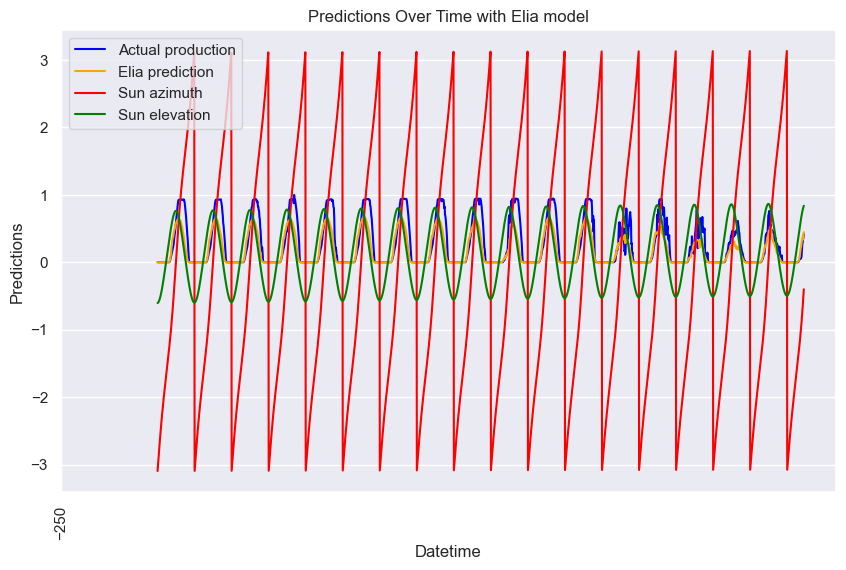

In [39]:
plt.figure(figsize=(10, 6))
plt.plot(df_test_jvr['production_15_min_%'], label='Actual production', color='blue')
plt.plot(df_test_jvr['Predicted_%'], label='Elia prediction', color='orange')
plt.plot(df_test_jvr['solar_azimuth'], label='Sun azimuth', color='red')
plt.plot(df_test_jvr['solar_elevation'], label='Sun elevation', color='green')
plt.xlabel('Datetime')
plt.ylabel('Predictions')
plt.title('Predictions Over Time with Elia model')
plt.grid(True) 
x_ticks = plt.gca().get_xticks() 
x_ticks_selected = x_ticks[::24] 
plt.xticks(x_ticks_selected, rotation=90)
plt.legend()
plt.show()

In [40]:
# Hier maken we een afsplitsing voor een andere dataset geschikt voor de LSTM modellen
df_jvr_lstm = df_jvr.copy()
df_ddp_lstm = df_ddp.copy()
df_test_jvr_lstm = df_test_jvr.copy()
df_test_jvr_lstm.drop(columns=['Predicted_%'], inplace=True)

In [41]:
# Hier maken we een afsplitsing voor het trainen van een Prophet model
df_prophet = df_jvr.copy()
df_prophet_test = df_test_jvr.copy()
df_prophet.rename(columns={'datetime': 'ds', 'production_15_min_%': 'y'}, inplace=True)
df_prophet_test.rename(columns={'datetime': 'ds', 'production_15_min_%': 'y'}, inplace=True)
df_prophet.head(10)

,ds,y,temp,cloudcover,solarenergy,uvindex,solar_azimuth,solar_elevation
0,2024-03-14 08:15:00,0.092,8.325,54.475,0.325,0.5,-1.054120,0.330412
1,2024-03-14 08:45:00,0.387,9.175,46.225,0.575,1.5,-0.935324,0.399732
2,2024-03-14 09:00:00,0.231,9.600,42.100,0.700,2.0,-0.873267,0.432229
3,2024-03-14 09:15:00,0.203,10.000,48.875,0.900,2.5,-0.809274,0.463056
4,2024-03-14 09:30:00,0.172,10.400,55.650,1.100,3.0,-0.743247,0.492032
5,2024-03-14 09:45:00,0.085,10.800,62.425,1.300,3.5,-0.675122,0.518972
6,2024-03-14 12:00:00,4.431,14.800,52.400,2.000,6.0,0.018610,0.640320
7,2024-03-14 12:15:00,0.826,14.925,50.300,1.850,5.5,0.100055,0.637944
8,2024-03-14 12:30:00,0.747,15.050,48.200,1.700,5.0,0.181001,0.632235
9,2024-03-14 12:45:00,0.404,15.175,46.100,1.550,4.5,0.261057,0.623258


In [42]:
# De trainingsdata van beide huizen samenvoegen
df_all = pd.concat([df_jvr, df_ddp], axis=0)

In [43]:
# Geef de dag van het jaar weer als een sinus- en cosinusgolf
# Dag van het jaar extraheren
df_all['day_of_year'] = df_all['datetime'].dt.dayofyear
df_test_jvr['day_of_year'] = df_test_jvr['datetime'].dt.dayofyear
df_jvr_lstm['day_of_year'] = df_jvr_lstm['datetime'].dt.dayofyear
df_ddp_lstm['day_of_year'] = df_ddp_lstm['datetime'].dt.dayofyear
df_test_jvr_lstm['day_of_year'] = df_test_jvr_lstm['datetime'].dt.dayofyear
df_prophet['day_of_year'] = df_prophet['ds'].dt.dayofyear
df_prophet_test['day_of_year'] = df_prophet_test['ds'].dt.dayofyear
# Bereken sinus- en cosinuswaarden voor day_of_year
df_all['day_of_year_sine'] = np.sin(2 * np.pi * df_all['day_of_year'] / 365)
df_all['day_of_year_cosine'] = np.cos(2 * np.pi * df_all['day_of_year'] / 365)
df_test_jvr['day_of_year_sine'] = np.sin(2 * np.pi * df_test_jvr['day_of_year'] / 365)
df_test_jvr['day_of_year_cosine'] = np.cos(2 * np.pi * df_test_jvr['day_of_year'] / 365)
df_jvr_lstm['day_of_year_sine'] = np.sin(2 * np.pi * df_jvr_lstm['day_of_year'] / 365)
df_jvr_lstm['day_of_year_cosine'] = np.cos(2 * np.pi * df_jvr_lstm['day_of_year'] / 365)
df_ddp_lstm['day_of_year_sine'] = np.sin(2 * np.pi * df_ddp_lstm['day_of_year'] / 365)
df_ddp_lstm['day_of_year_cosine'] = np.cos(2 * np.pi * df_ddp_lstm['day_of_year'] / 365)
df_test_jvr_lstm['day_of_year_sine'] = np.sin(2 * np.pi * df_test_jvr_lstm['day_of_year'] / 365)
df_test_jvr_lstm['day_of_year_cosine'] = np.cos(2 * np.pi * df_test_jvr_lstm['day_of_year'] / 365)
df_prophet['day_of_year_sine'] = np.sin(2 * np.pi * df_prophet['day_of_year'] / 365)
df_prophet['day_of_year_cosine'] = np.cos(2 * np.pi * df_prophet['day_of_year'] / 365)
df_prophet_test['day_of_year_sine'] = np.sin(2 * np.pi * df_prophet_test['day_of_year'] / 365)
df_prophet_test['day_of_year_cosine'] = np.cos(2 * np.pi * df_prophet_test['day_of_year'] / 365)

In [44]:
# Verwijder onnodige kolommen
df_all.drop(columns=['datetime', 'day_of_year'], inplace=True)
df_test_jvr.drop(columns=['datetime', 'day_of_year'], inplace=True)
df_jvr_lstm.drop(columns=['datetime', 'day_of_year'], inplace=True)
df_ddp_lstm.drop(columns=['datetime', 'day_of_year'], inplace=True)
df_test_jvr_lstm.drop(columns=['datetime', 'day_of_year'], inplace=True)
df_prophet.drop(columns=['day_of_year'], inplace=True)
df_prophet_test.drop(columns=['day_of_year'], inplace=True)
df_all.head()

,production_15_min_%,temp,cloudcover,solarenergy,uvindex,solar_azimuth,solar_elevation,day_of_year_sine,day_of_year_cosine
0,0.092,8.325,54.475,0.325,0.5,-1.054120,0.330412,0.956235,0.2926
1,0.387,9.175,46.225,0.575,1.5,-0.935324,0.399732,0.956235,0.2926
2,0.231,9.600,42.100,0.700,2.0,-0.873267,0.432229,0.956235,0.2926
3,0.203,10.000,48.875,0.900,2.5,-0.809274,0.463056,0.956235,0.2926
4,0.172,10.400,55.650,1.100,3.0,-0.743247,0.492032,0.956235,0.2926


In [45]:
# Vervang alle negatieve energiewaarden (%) met 0
df_all['production_15_min_%'] = df_all['production_15_min_%'].apply(lambda x: x if x >= 0 else 0)
df_prophet['y'] = df_prophet['y'].apply(lambda x: x if x >= 0 else 0)
df_test_jvr['production_15_min_%'] = df_test_jvr['production_15_min_%'].apply(lambda x: x if x >= 0 else 0)
df_jvr_lstm['production_15_min_%'] = df_jvr_lstm['production_15_min_%'].apply(lambda x: x if x >= 0 else 0)
df_ddp_lstm['production_15_min_%'] = df_ddp_lstm['production_15_min_%'].apply(lambda x: x if x >= 0 else 0)
df_test_jvr_lstm['production_15_min_%'] = df_test_jvr_lstm['production_15_min_%'].apply(lambda x: x if x >= 0 else 0)
df_prophet_test['y'] = df_prophet_test['y'].apply(lambda x: x if x >= 0 else 0)
df_all.describe()

,production_15_min_%,temp,cloudcover,solarenergy,uvindex,solar_azimuth,solar_elevation,day_of_year_sine,day_of_year_cosine
count,63415.000000,63415.000000,63415.000000,63415.000000,63415.000000,63415.000000,63415.000000,63415.000000,63415.000000
mean,0.413067,12.034493,74.968634,0.396069,1.085796,-0.001481,0.021327,-0.046224,-0.050979
std,70.659857,6.266740,27.235567,0.658820,1.847114,1.788755,0.535527,0.691740,0.718871
min,0.000000,-2.700000,0.000000,0.000000,0.000000,-3.141515,-1.092474,-0.999991,-0.999963
25%,0.000000,7.500000,60.000000,0.000000,0.000000,-1.588803,-0.361215,-0.717677,-0.755493
50%,0.000000,12.250000,87.150000,0.000000,0.000000,-0.004863,0.016922,-0.085965,-0.133015
75%,0.165000,16.450000,96.600000,0.550000,1.500000,1.583733,0.414121,0.587785,0.690173
max,17793.070000,33.900000,100.000000,3.900000,10.000000,3.141587,1.092256,0.999991,1.000000


In [46]:
df_prophet.describe()

,ds,y,temp,cloudcover,solarenergy,uvindex,solar_azimuth,solar_elevation,day_of_year_sine,day_of_year_cosine
count,33537,33537.000000,33537.000000,33537.000000,33537.000000,33537.000000,33537.000000,33537.000000,3.353700e+04,33537.000000
mean,2024-09-13 23:14:26.964844800,0.692431,11.774091,73.297355,0.382590,1.046814,-0.002160,0.015735,-6.668996e-04,-0.025967
min,2024-03-14 08:15:00,0.000000,-2.600000,0.000000,0.000000,0.000000,-3.141515,-1.091153,-9.999907e-01,-0.999963
25%,2024-06-14 11:30:00,0.000000,7.200000,56.300000,0.000000,0.000000,-1.585593,-0.369438,-6.870528e-01,-0.732494
50%,2024-09-09 22:45:00,0.000000,11.900000,85.750000,0.000000,0.000000,-0.004490,0.012125,6.432491e-16,-0.030120
75%,2024-12-13 12:30:00,0.218000,16.200000,96.300000,0.500000,1.500000,1.581511,0.410080,7.295576e-01,0.677615
max,2025-03-31 23:00:00,17793.070000,33.700000,100.000000,3.600000,10.000000,3.141499,1.090954,9.999907e-01,1.000000
std,NaN,97.162851,6.272704,28.382048,0.637192,1.786806,1.785709,0.533342,7.034028e-01,0.710338


In [47]:
# maak het percentage energie een een waarde tussen 0 en 100%
df_all['production_15_min_%'] = df_all['production_15_min_%'] * 100
df_test_jvr['production_15_min_%'] = df_test_jvr['production_15_min_%'] * 100
df_jvr_lstm['production_15_min_%'] = df_jvr_lstm['production_15_min_%'] * 100
df_ddp_lstm['production_15_min_%'] = df_ddp_lstm['production_15_min_%'] * 100
df_test_jvr_lstm['production_15_min_%'] = df_test_jvr_lstm['production_15_min_%'] * 100
df_prophet['y'] = df_prophet['y'] * 100
df_prophet_test['y'] = df_prophet_test['y'] * 100

In [48]:
# Estetic action move target column to the end
df_all = pd.concat([df_all.drop('production_15_min_%', axis=1), df_all['production_15_min_%']], axis=1)
df_jvr_lstm = pd.concat([df_jvr_lstm.drop('production_15_min_%', axis=1), df_jvr_lstm['production_15_min_%']], axis=1)
df_ddp_lstm = pd.concat([df_ddp_lstm.drop('production_15_min_%', axis=1), df_ddp_lstm['production_15_min_%']], axis=1)
df_all.head()

,temp,cloudcover,solarenergy,uvindex,solar_azimuth,solar_elevation,day_of_year_sine,day_of_year_cosine,production_15_min_%
0,8.325,54.475,0.325,0.5,-1.054120,0.330412,0.956235,0.2926,9.2
1,9.175,46.225,0.575,1.5,-0.935324,0.399732,0.956235,0.2926,38.7
2,9.600,42.100,0.700,2.0,-0.873267,0.432229,0.956235,0.2926,23.1
3,10.000,48.875,0.900,2.5,-0.809274,0.463056,0.956235,0.2926,20.3
4,10.400,55.650,1.100,3.0,-0.743247,0.492032,0.956235,0.2926,17.2


In [49]:
df_all.describe()

,temp,cloudcover,solarenergy,uvindex,solar_azimuth,solar_elevation,day_of_year_sine,day_of_year_cosine,production_15_min_%
count,63415.000000,63415.000000,63415.000000,63415.000000,63415.000000,63415.000000,63415.000000,63415.000000,6.341500e+04
mean,12.034493,74.968634,0.396069,1.085796,-0.001481,0.021327,-0.046224,-0.050979,4.130667e+01
std,6.266740,27.235567,0.658820,1.847114,1.788755,0.535527,0.691740,0.718871,7.065986e+03
min,-2.700000,0.000000,0.000000,0.000000,-3.141515,-1.092474,-0.999991,-0.999963,0.000000e+00
25%,7.500000,60.000000,0.000000,0.000000,-1.588803,-0.361215,-0.717677,-0.755493,0.000000e+00
50%,12.250000,87.150000,0.000000,0.000000,-0.004863,0.016922,-0.085965,-0.133015,0.000000e+00
75%,16.450000,96.600000,0.550000,1.500000,1.583733,0.414121,0.587785,0.690173,1.650000e+01
max,33.900000,100.000000,3.900000,10.000000,3.141587,1.092256,0.999991,1.000000,1.779307e+06


In [50]:
# Alle waarden boven de 100(%) zijn uitschieters (dit zijn waarschijnlijk fouten als gevolg van ontbrekende gegevens). Deze worden verwijderd.
df_all = df_all[df_all['production_15_min_%'] <= 100]
df_all.describe()

,temp,cloudcover,solarenergy,uvindex,solar_azimuth,solar_elevation,day_of_year_sine,day_of_year_cosine,production_15_min_%
count,63404.000000,63404.000000,63404.000000,63404.000000,63404.000000,63404.000000,63404.000000,63404.000000,63404.000000
mean,12.034342,74.967853,0.396094,1.085858,-0.001293,0.021340,-0.046328,-0.050966,12.649570
std,6.267180,27.236478,0.658831,1.847131,1.788723,0.535551,0.691682,0.718921,21.759521
min,-2.700000,0.000000,0.000000,0.000000,-3.141515,-1.092474,-0.999991,-0.999963,0.000000
25%,7.500000,60.000000,0.000000,0.000000,-1.588716,-0.361158,-0.717677,-0.755493,0.000000
50%,12.250000,87.150000,0.012500,0.000000,-0.004679,0.016972,-0.085965,-0.133015,0.000000
75%,16.450000,96.606250,0.550000,1.500000,1.583822,0.414159,0.587785,0.690173,16.410256
max,33.900000,100.000000,3.900000,10.000000,3.141587,1.092256,0.999991,1.000000,94.900000


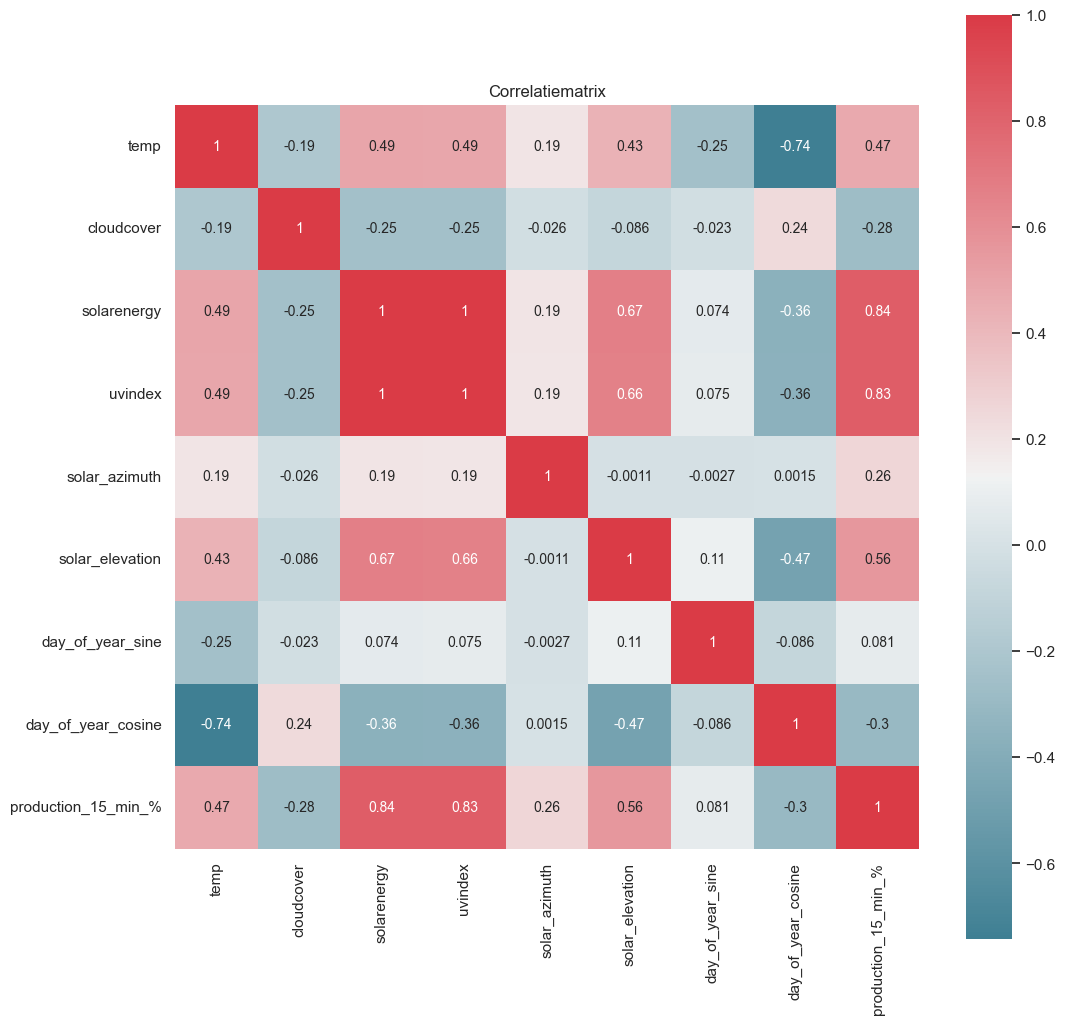

In [51]:
# Lineaire correlatie tussen de features - heatmap
# Visualiseer de onderlinge correlatiecoëfficiënten
f, ax = plt.subplots(figsize=(12, 12))
corr = df_all.corr()
sns.heatmap(
    corr,
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    square=True,
    ax=ax,
    annot=True,
    annot_kws={"size": 10}
)
plt.title("Correlatiematrix")
plt.show()

In [52]:
df_prophet.sort_values(by='ds', inplace=True)
df_prophet_test.sort_values(by='ds', inplace=True)
df_prophet = df_prophet.reset_index(drop=True)
df_prophet_test = df_prophet_test.reset_index(drop=True)
df_prophet.head(10)

,ds,y,temp,cloudcover,solarenergy,uvindex,solar_azimuth,solar_elevation,day_of_year_sine,day_of_year_cosine
0,2024-03-14 08:15:00,9.2,8.325,54.475,0.325,0.5,-1.054120,0.330412,0.956235,0.2926
1,2024-03-14 08:45:00,38.7,9.175,46.225,0.575,1.5,-0.935324,0.399732,0.956235,0.2926
2,2024-03-14 09:00:00,23.1,9.600,42.100,0.700,2.0,-0.873267,0.432229,0.956235,0.2926
3,2024-03-14 09:15:00,20.3,10.000,48.875,0.900,2.5,-0.809274,0.463056,0.956235,0.2926
4,2024-03-14 09:30:00,17.2,10.400,55.650,1.100,3.0,-0.743247,0.492032,0.956235,0.2926
5,2024-03-14 09:45:00,8.5,10.800,62.425,1.300,3.5,-0.675122,0.518972,0.956235,0.2926
6,2024-03-14 12:00:00,443.1,14.800,52.400,2.000,6.0,0.018610,0.640320,0.956235,0.2926
7,2024-03-14 12:15:00,82.6,14.925,50.300,1.850,5.5,0.100055,0.637944,0.956235,0.2926
8,2024-03-14 12:30:00,74.7,15.050,48.200,1.700,5.0,0.181001,0.632235,0.956235,0.2926
9,2024-03-14 12:45:00,40.4,15.175,46.100,1.550,4.5,0.261057,0.623258,0.956235,0.2926


In [53]:
# Bewaren van train en test dataframes als parquet files
df_all.to_parquet('datasets/pv_train_data.parquet', index=False)
df_test_jvr.to_parquet('datasets/pv_test_data.parquet', index=False)
df_prophet.to_parquet('datasets/pv_prophet_train_data.parquet', index=False)
df_prophet_test.to_parquet('datasets/pv_prophet_test_data.parquet', index=False)
df_jvr_lstm.to_parquet('datasets/pv_jvr_lstm_train_data.parquet', index=False)
df_ddp_lstm.to_parquet('datasets/pv_ddp_lstm_train_data.parquet', index=False)
df_test_jvr_lstm.to_parquet('datasets/pv_test_jvr_lstm.parquet', index=False)

## Inladen van Parquet data

Als je niet beschikt over data of de CSV bestanden met weers- en productie data kan je deze voorbewerkte Parquet bestanden inladen en gebruiken.

In [54]:
df = pd.read_parquet('datasets/pv_train_data.parquet')
df_test = pd.read_parquet('datasets/pv_test_data.parquet')
df_prophet = pd.read_parquet('datasets/pv_prophet_train_data.parquet')
df_prophet_test = pd.read_parquet('datasets/pv_prophet_test_data.parquet')
df_jvr_lstm = pd.read_parquet('datasets/pv_jvr_lstm_train_data.parquet')
df_ddp_lstm = pd.read_parquet('datasets/pv_ddp_lstm_train_data.parquet')
df_lstm_test = pd.read_parquet('datasets/pv_test_jvr_lstm.parquet')

## Pre-processing van de data

### Voor ML en NN model:

In [55]:
# Splits de dataset in een trainings- en testset
y = df['production_15_min_%']
X = df.drop(['production_15_min_%'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [56]:
# De gegevens schalen. Aangezien er geen outliers zijn, kunnen we de MinMaxScaler gebruiken
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Logistic regression
polynomial = PolynomialFeatures(2)
polynomial.fit(X_train)
X_train = polynomial.transform(X_train)
X_test = polynomial.transform(X_test)

### LSTM 2h in de toekomst:

In [57]:
def create_sequences(data, target, n_steps_in, n_steps_out):
    X, y = [], []
    for i in range(len(data) - n_steps_in - n_steps_out + 1):
        X.append(data[i:i+n_steps_in])
        y.append(target[i+n_steps_in+n_steps_out-1 : i+n_steps_in+n_steps_out])
    return np.array(X), np.array(y)

df_jvr_lstm_target = df_jvr_lstm['production_15_min_%'].values
df_ddp_lstm_target = df_ddp_lstm['production_15_min_%'].values
df_lstm_test_target = df_lstm_test['production_15_min_%'].values
df_jvr_lstm_values = df_jvr_lstm.copy()
df_ddp_lstm_values = df_ddp_lstm.copy()
df_lstm_test_values = df_lstm_test.copy()
df_jvr_lstm_values.drop(columns=['production_15_min_%'], inplace=True)
df_ddp_lstm_values.drop(columns=['production_15_min_%'], inplace=True)
df_lstm_test_values.drop(columns=['production_15_min_%'], inplace=True)
# Reshape de dataframes naar een 3D-array for a predictie van 2 uur
X_jvr_2_hours, y_jvr_2_hours = create_sequences(df_jvr_lstm_values.values, df_jvr_lstm_target, 100, 8)
X_ddp_2_hours, y_ddp_2_hours = create_sequences(df_ddp_lstm_values.values, df_ddp_lstm_target, 100, 8)
X_test_2_hours, y_test_2_hours = create_sequences(df_lstm_test_values.values, df_lstm_test_target, 100, 8)
print(f"X_jvr_2_hours shape: {X_test_2_hours.shape}")
print(f"y_jvr_2_hours shape: {y_test_2_hours.shape}")
print(y_jvr_2_hours)

X_jvr_2_hours shape: (1569, 100, 8)
y_jvr_2_hours shape: (1569, 1)
[[35.6]
 [35.3]
 [20.4]
 ...
 [ 0. ]
 [ 0. ]
 [ 0. ]]


In [58]:
# Samenvoegen van de datasets
X_2_hours = np.concatenate((X_jvr_2_hours, X_ddp_2_hours), axis=0)
y_2_hours = np.concatenate((y_jvr_2_hours, y_ddp_2_hours), axis=0)

print(f"X_2_hours shape: {X_2_hours.shape}")
print(f"y_2_hours shape: {y_2_hours.shape}")

assert len(X_2_hours) == len(y_2_hours)

permutation_2h = np.random.permutation(len(X_2_hours))
X_shuffled_2h = X_2_hours[permutation_2h]
y_shuffled_2h = y_2_hours[permutation_2h]


lstm_2_scaler = MinMaxScaler()
X_shuffled_2h = lstm_2_scaler.fit_transform(X_shuffled_2h.reshape(-1, X_shuffled_2h.shape[-1])).reshape(X_shuffled_2h.shape)

X_2_hours shape: (63201, 100, 8)
y_2_hours shape: (63201, 1)


### LSTM 24h in de toekomst:

In [59]:
# Reshape de dataframes naar een 3D-array for a predictie van 2 uur
X_jvr_24_hours, y_jvr_24_hours = create_sequences(df_jvr_lstm_values.values, df_jvr_lstm_target, 100, 96)
X_ddp_24_hours, y_ddp_24_hours = create_sequences(df_ddp_lstm_values.values, df_ddp_lstm_target, 100, 96)
X_test_24_hours, y_test_24_hours = create_sequences(df_lstm_test_values.values, df_lstm_test_target, 100, 96)
print(f"X_jvr_24_hours shape: {X_test_24_hours.shape}")
print(f"y_jvr_24_hours shape: {y_test_24_hours.shape}")
print(y_jvr_24_hours)

X_jvr_24_hours shape: (1481, 100, 8)
y_jvr_24_hours shape: (1481, 1)
[[22.6]
 [21.9]
 [28.7]
 ...
 [ 0. ]
 [ 0. ]
 [ 0. ]]


In [60]:
# Samenvoegen van de datasets
X_24_hours = np.concatenate((X_jvr_24_hours, X_ddp_24_hours), axis=0)
y_24_hours = np.concatenate((y_jvr_24_hours, y_ddp_24_hours), axis=0)

print(f"X_24_hours shape: {X_24_hours.shape}")
print(f"y_24_hours shape: {y_24_hours.shape}")

assert len(X_24_hours) == len(y_24_hours)

permutation_24h = np.random.permutation(len(X_24_hours))
X_shuffled_24h = X_24_hours[permutation_24h]
y_shuffled_24h = y_24_hours[permutation_24h]


lstm_24_scaler = MinMaxScaler()
X_shuffled_24h = lstm_24_scaler.fit_transform(X_shuffled_24h.reshape(-1, X_shuffled_24h.shape[-1])).reshape(X_shuffled_24h.shape)

X_24_hours shape: (63025, 100, 8)
y_24_hours shape: (63025, 1)


## Training

### Klassiek machine learning random forest model

In [ ]:
# Verschillende hyperparameters uitproberen voor de Random Forest Regressor
estimators = [10, 50, 100, 150, 200]
rf_depths = [10, 15, 20, 25, 30, 45, 50]

In [62]:
# Trainen van elke combinatie van hyperparameters en opslaan van het beste model
best_score = 0
best_model = None
for estimator in estimators:
    for depth in rf_depths:
        print(f"Training model with estimators: {estimator}, depth: {depth}")
        rf_model = RandomForestRegressor(n_estimators=estimator, max_depth=depth)
        rf_model.fit(X_train, y_train)
        score = rf_model.score(X_test, y_test)
        print(f"Model score: {score}")
        if score > best_score:
            best_score = score
            best_model = rf_model
            # Save the model
            print(f"New best model found with estimators: {estimator}, depth: {depth}, and score: {score}")
            with open(f'models/pv_ML.pkl', 'wb') as file:
                pickle.dump(rf_model, file)

Training model with estimators: 10, depth: 10
Model score: 0.8534342106791575
New best model found with estimators: 10, depth: 10, and score: 0.8534342106791575


### Sequentieel neuraal netwerk

In [63]:
neural_network_model = Sequential()
# De input Layer :
neural_network_model.add(Dense(64,input_dim = X_train.shape[1], activation='relu'))
# De hidden Layer(s) :
neural_network_model.add(Dense(32, activation='relu'))
# De output Layer :
neural_network_model.add(Dense(1, kernel_initializer='normal',activation='linear'))
# Compilen van het netwerk :
neural_network_model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])
neural_network_model.summary()

checkpoint_name = 'pv_DL.h5' 
checkpoint = ModelCheckpoint(f'models/{checkpoint_name}', monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
callbacks_list = [checkpoint]

history = neural_network_model.fit(X_train, y_train, epochs=40, batch_size=1000, validation_split = 0.2, callbacks=callbacks_list)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                2944      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 5057 (19.75 KB)
Trainable params: 5057 (19.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/40
 1/41 [..............................] - ETA: 7s - loss: 706.3650 - mean_squared_error: 706.3650
Epoch 1: val_loss improved from inf to 570.03448, saving model to models/pv_DL.h5
41/41 [==============================] - 0s 3ms/step - loss: 617.2302 - mean_squared_error: 617.

/Users/thijspirmez/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 5: val_loss improved from 134.09149 to 122.90333, saving model to models/pv_DL.h5
41/41 [==============================] - 0s 1ms/step - loss: 131.4723 - mean_squared_error: 131.4723 - val_loss: 122.9033 - val_mean_squared_error: 122.9033
Epoch 6/40
 1/41 [..............................] - ETA: 0s - loss: 127.8507 - mean_squared_error: 127.8507
Epoch 6: val_loss improved from 122.90333 to 118.31264, saving model to models/pv_DL.h5
41/41 [==============================] - 0s 1ms/step - loss: 124.0669 - mean_squared_error: 124.0669 - val_loss: 118.3126 - val_mean_squared_error: 118.3126
Epoch 7/40
 1/41 [..............................] - ETA: 0s - loss: 125.0465 - mean_squared_error: 125.0465
Epoch 7: val_loss improved from 118.31264 to 114.35007, saving model to models/pv_DL.h5
41/41 [==============================] - 0s 1ms/step - loss: 119.4229 - mean_squared_error: 119.4229 - val_loss: 114.3501 - val_mean_squared_error: 114.3501
Epoch 8/40
 1/41 [..............................

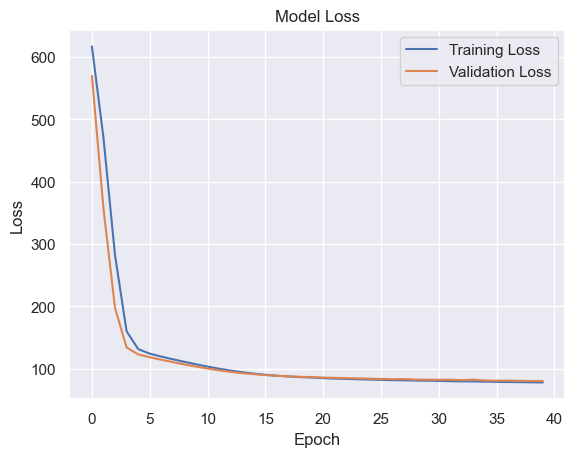

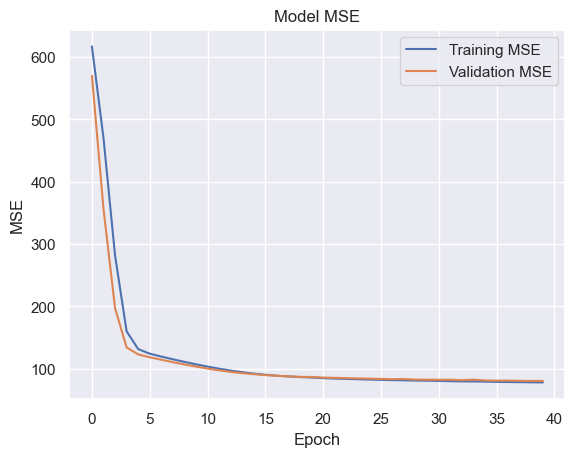

In [64]:
# Plot training en validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training en validation MAE
plt.plot(history.history['mean_squared_error'], label='Training MSE')
plt.plot(history.history['val_mean_squared_error'], label='Validation MSE')
plt.title('Model MSE')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.show()

### META's Prophet model:

In [65]:
prophet_model = Prophet()
prophet_model.add_regressor('temp')
prophet_model.add_regressor('cloudcover')
prophet_model.add_regressor('solarenergy')
prophet_model.add_regressor('uvindex')
prophet_model.add_regressor('solar_azimuth')
prophet_model.add_regressor('solar_elevation')
prophet_model.add_regressor('day_of_year_sine')
prophet_model.add_regressor('day_of_year_cosine')
prophet_model.fit(df_prophet)

08:17:43 - cmdstanpy - INFO - Chain [1] start processing
08:17:45 - cmdstanpy - INFO - Chain [1] done processing


### LSTM 2h in de toekomst:

In [66]:
LSTM_network_model_2_hour = Sequential()

LSTM_network_model_2_hour.add(LSTM(128, return_sequences=True, activation='tanh', input_shape=(100, 8)))
LSTM_network_model_2_hour.add(Dropout(0.2))
LSTM_network_model_2_hour.add(LSTM(64, activation='tanh'))
LSTM_network_model_2_hour.add(Dense(32, activation='relu'))
LSTM_network_model_2_hour.add(Dense(1, activation='linear'))

LSTM_network_model_2_hour.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])
LSTM_network_model_2_hour.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 128)          70144     
                                                                 
 dropout (Dropout)           (None, 100, 128)          0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dense_3 (Dense)             (None, 32)                2080      
                                                                 
 dense_4 (Dense)             (None, 1)                 33        
                                                                 
Total params: 121665 (475.25 KB)
Trainable params: 121665 (475.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [67]:
checkpoint_name = 'pv_lstm_2_hours_ahead.h5' 
checkpoint = ModelCheckpoint(f'models/{checkpoint_name}', monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
callbacks_list = [checkpoint]

In [ ]:
history_2_hours = LSTM_network_model_2_hour.fit(X_shuffled_2h, y_shuffled_2h, epochs=40, batch_size=400, validation_split = 0.2, callbacks=callbacks_list)

127/127 [==============================] - ETA: 0s - loss: 62619112.0000 - mean_squared_error: 62619112.0000
Epoch 1: val_loss improved from inf to 15569.32812, saving model to models/pv_lstm_2_hours_ahead.h5
127/127 [==============================] - 60s 467ms/step - loss: 62619112.0000 - mean_squared_error: 62619112.0000 - val_loss: 15569.3281 - val_mean_squared_error: 15569.3281


/Users/thijspirmez/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


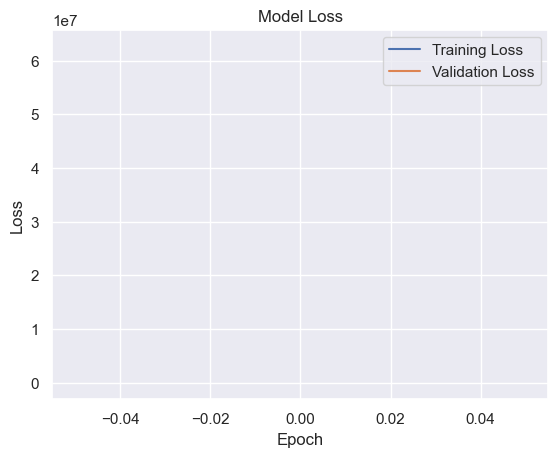

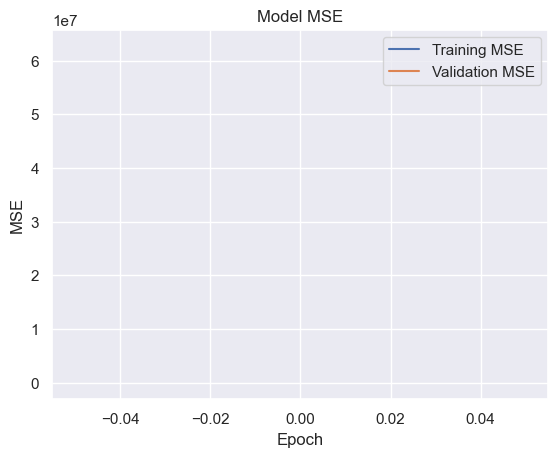

In [69]:
# Plot training and validation loss
plt.plot(history_2_hours.history['loss'], label='Training Loss')
plt.plot(history_2_hours.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation MAE
plt.plot(history_2_hours.history['mean_squared_error'], label='Training MSE')
plt.plot(history_2_hours.history['val_mean_squared_error'], label='Validation MSE')
plt.title('Model MSE')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.show()

### LSTM 24h in de toekomst:

In [70]:
LSTM_network_model_24_hour = Sequential()

LSTM_network_model_24_hour.add(LSTM(128, return_sequences=True, activation='tanh', input_shape=(100, 8)))
LSTM_network_model_24_hour.add(Dropout(0.2))
LSTM_network_model_24_hour.add(LSTM(64, activation='tanh'))
LSTM_network_model_24_hour.add(Dense(32, activation='relu'))
LSTM_network_model_24_hour.add(Dense(1, activation='linear'))

LSTM_network_model_24_hour.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])
LSTM_network_model_24_hour.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 100, 128)          70144     
                                                                 
 dropout_1 (Dropout)         (None, 100, 128)          0         
                                                                 
 lstm_3 (LSTM)               (None, 64)                49408     
                                                                 
 dense_5 (Dense)             (None, 32)                2080      
                                                                 
 dense_6 (Dense)             (None, 1)                 33        
                                                                 
Total params: 121665 (475.25 KB)
Trainable params: 121665 (475.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [71]:
checkpoint_name = 'pv_lstm_24_hours_ahead.h5' 
checkpoint = ModelCheckpoint(f'models/{checkpoint_name}', monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
callbacks_list = [checkpoint]

In [ ]:
history_24_hours = LSTM_network_model_24_hour.fit(X_shuffled_24h, y_shuffled_24h, epochs=40, batch_size=400, validation_split = 0.2, callbacks=callbacks_list)

127/127 [==============================] - ETA: 0s - loss: 62796352.0000 - mean_squared_error: 62796352.0000
Epoch 1: val_loss improved from inf to 485.75165, saving model to models/pv_lstm_24_hours_ahead.h5
127/127 [==============================] - 63s 483ms/step - loss: 62796352.0000 - mean_squared_error: 62796352.0000 - val_loss: 485.7516 - val_mean_squared_error: 485.7516


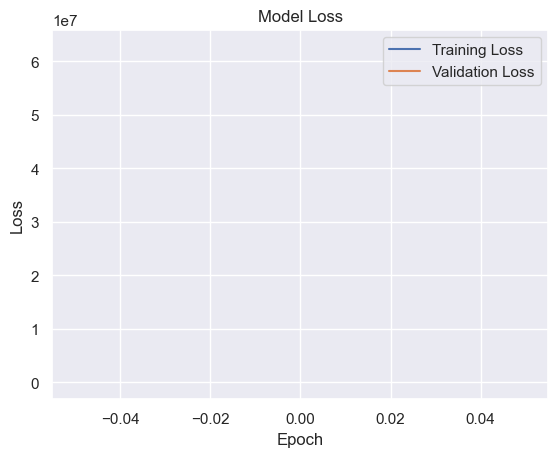

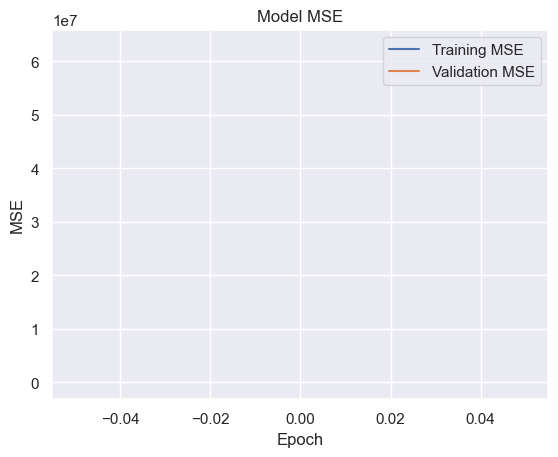

In [73]:
# Plot training and validation loss
plt.plot(history_24_hours.history['loss'], label='Training Loss')
plt.plot(history_24_hours.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation MAE
plt.plot(history_24_hours.history['mean_squared_error'], label='Training MSE')
plt.plot(history_24_hours.history['val_mean_squared_error'], label='Validation MSE')
plt.title('Model MSE')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.show()

## Testen op ongeziene data

### Testdata preprocessen

#### Voorbereiden test dataframe voor ML, NN en Prophet:

In [74]:
# Controler van de test dataframes
df_test.head()

,production_15_min_%,temp,cloudcover,solarenergy,uvindex,solar_azimuth,solar_elevation,Predicted_%,day_of_year_sine,day_of_year_cosine
0,0.0,5.700,10.0,0.0,0.0,-3.096242,-0.604923,0.0,0.999991,0.004304
1,0.0,5.575,10.0,0.0,0.0,-3.017099,-0.601352,0.0,0.999991,0.004304
2,0.0,5.450,10.0,0.0,0.0,-2.938549,-0.594553,0.0,0.999991,0.004304
3,0.0,5.325,10.0,0.0,0.0,-2.860933,-0.584599,0.0,0.999991,0.004304
4,0.0,5.200,10.0,0.0,0.0,-2.784555,-0.571593,0.0,0.999991,0.004304


In [75]:
actual = df_test[['production_15_min_%']]
elia = df_test[['Predicted_%']]
input = df_test.drop(['production_15_min_%', 'Predicted_%'], axis=1)
input.head()

,temp,cloudcover,solarenergy,uvindex,solar_azimuth,solar_elevation,day_of_year_sine,day_of_year_cosine
0,5.700,10.0,0.0,0.0,-3.096242,-0.604923,0.999991,0.004304
1,5.575,10.0,0.0,0.0,-3.017099,-0.601352,0.999991,0.004304
2,5.450,10.0,0.0,0.0,-2.938549,-0.594553,0.999991,0.004304
3,5.325,10.0,0.0,0.0,-2.860933,-0.584599,0.999991,0.004304
4,5.200,10.0,0.0,0.0,-2.784555,-0.571593,0.999991,0.004304


In [76]:
# Voeg de gemeten productie waarden toe aan de df_result dataframe
df_result = actual[['production_15_min_%']]
print(df_result)

      production_15_min_%
0                     0.0
1                     0.0
2                     0.0
3                     0.0
4                     0.0
...                   ...
1671                 26.0
1672                 29.5
1673                 33.4
1674                 37.2
1675                 41.8

[1676 rows x 1 columns]


In [77]:
# Schaal de input data en pas de polynomiale transformatie toe
input = scaler.transform(input)
input = polynomial.transform(input)

#### Voorbereiden test dataframe voor LSTM 2h ahead:

In [78]:
df_lstm_test.head()
actual_lstm_2_hours = y_test_2_hours
input_lstm_2_hours = X_test_2_hours

#### Voorbereiden test dataframe voor LSTM 24h ahead:

In [79]:
actual_lstm_24_hours = y_test_24_hours
input_lstm_24_hours = X_test_24_hours

### Modellen testen op testset

#### Testen van ML-model

In [80]:
# Inladen en voorspellen met het beste ML model
with open('models/pv_ML.pkl', 'rb') as file:
    best_ml_model = pickle.load(file)
df_result['predicted_with_ML(%)'] = best_ml_model.predict(input)
df_result.head()

,production_15_min_%,predicted_with_ML(%)
0,0.0,0.003001
1,0.0,0.003001
2,0.0,0.003001
3,0.0,0.003001
4,0.0,0.003001


#### Testen van NN-model

In [81]:
# Inladen en voorspellen met het beste NN model
best_nn_model = load_model('models/pv_DL.h5')
df_result['predicted_with_NN(%)'] = best_nn_model.predict(input)
df_result['predicted_with_NN(%)'] = df_result['predicted_with_NN(%)'].apply(lambda x: x if x >= 0 else 0)
df_result.head()

53/53 [==============================] - 0s 382us/step


,production_15_min_%,predicted_with_ML(%),predicted_with_NN(%)
0,0.0,0.003001,0.0
1,0.0,0.003001,0.0
2,0.0,0.003001,0.0
3,0.0,0.003001,0.0
4,0.0,0.003001,0.0


#### Testen van Prophet-model

In [82]:
# Inladen en voorspellen met het Prophet model
df_prophet_test.drop(['y'], axis=1)
df_result['predicted_with_Prophet(%)'] = prophet_model.predict(df_prophet_test)['yhat']
df_result.head()

,production_15_min_%,predicted_with_ML(%),predicted_with_NN(%),predicted_with_Prophet(%)
0,0.0,0.003001,0.0,223.461331
1,0.0,0.003001,0.0,303.939866
2,0.0,0.003001,0.0,385.291235
3,0.0,0.003001,0.0,464.204210
4,0.0,0.003001,0.0,537.379495


#### Testen van Elia-model

In [83]:
# Elia data toevoegen aan de df_result dataframe
df_result['predicted_with_Elia(%)'] = elia['Predicted_%'].values * 100
df_result.head(1000)

,production_15_min_%,predicted_with_ML(%),predicted_with_NN(%),predicted_with_Prophet(%),predicted_with_Elia(%)
0,0.0,0.003001,0.000000,223.461331,0.000000
1,0.0,0.003001,0.000000,303.939866,0.000000
2,0.0,0.003001,0.000000,385.291235,0.000000
3,0.0,0.003001,0.000000,464.204210,0.000000
4,0.0,0.003001,0.000000,537.379495,0.000000
...,...,...,...,...,...
995,11.6,12.474452,10.683593,-4.849446,15.901113
996,16.1,13.584659,13.176115,-4.109902,21.338113
997,18.1,15.588926,14.228133,-22.200937,25.971362
998,20.8,20.612113,16.838833,-44.731621,30.576722


#### Testen van het LSTM 2h-ahead model

In [84]:
# Inladen van het beste LSTM model op 2h
lstm_2_hour = load_model('models/pv_lstm_2_hours_ahead.h5')
# Maak een voorspelling voor elke regel in de testdataset
input_lstm_2_hours = lstm_2_scaler.transform(input_lstm_2_hours.reshape(-1, input_lstm_2_hours.shape[-1])).reshape(input_lstm_2_hours.shape)
df_result_lstm_2_hour = pd.DataFrame(actual_lstm_2_hours, columns=['production_15_min_%'])

In [85]:
df_result_lstm_2_hour['predicted_with_LSTM_2_hour(%)'] = lstm_2_hour.predict(input_lstm_2_hours)
df_result_lstm_2_hour['predicted_with_LSTM_2_hour(%)'] = df_result_lstm_2_hour['predicted_with_LSTM_2_hour(%)'].apply(lambda x: x if x >= 0 else 0)
df_result_lstm_2_hour.head()

50/50 [==============================] - 2s 25ms/step


,production_15_min_%,predicted_with_LSTM_2_hour(%)
0,0.0,11.379807
1,0.0,11.379845
2,0.0,11.379885
3,0.0,11.379927
4,0.0,11.379969


#### Testen van het LSTM 24h-ahead model

In [86]:
# Inladen van het beste LSTM model op 2h
lstm_24_hour = load_model('models/pv_lstm_24_hours_ahead.h5')
# Maak een voorspelling voor elke regel in de testdataset
input_lstm_24_hours = lstm_24_scaler.transform(input_lstm_24_hours.reshape(-1, input_lstm_24_hours.shape[-1])).reshape(input_lstm_24_hours.shape)
df_result_lstm_24_hour = pd.DataFrame(actual_lstm_24_hours, columns=['production_15_min_%'])

In [87]:
df_result_lstm_24_hour['predicted_with_LSTM_24_hour(%)'] = lstm_24_hour.predict(input_lstm_24_hours)
df_result_lstm_24_hour['predicted_with_LSTM_24_hour(%)'] = df_result_lstm_24_hour['predicted_with_LSTM_24_hour(%)'].apply(lambda x: x if x >= 0 else 0)
df_result_lstm_24_hour.head()

47/47 [==============================] - 1s 23ms/step


,production_15_min_%,predicted_with_LSTM_24_hour(%)
0,0.0,16.145306
1,0.0,16.145315
2,0.0,16.145330
3,0.0,16.145351
4,0.0,16.145374


### Besluitvorming rond testen

#### ML, NN en Elia

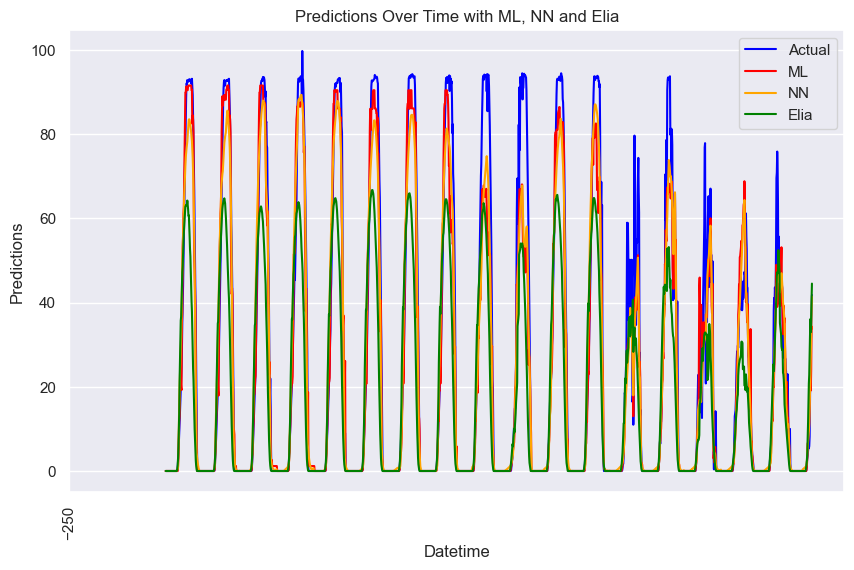

In [88]:
# Zet de voorspellingen uit in een grafiek
plt.figure(figsize=(10, 6))
plt.plot(df_result['production_15_min_%'], label='Actual', color='blue')
plt.plot(df_result['predicted_with_ML(%)'], label='ML', color='red')
plt.plot(df_result['predicted_with_NN(%)'], label='NN', color='orange')
#plt.plot(df_result['predicted_with_Prophet(%)'], label='Prophet', color='yellow')
plt.plot(df_result['predicted_with_Elia(%)'], label='Elia', color='green')
plt.xlabel('Datetime')
plt.ylabel('Predictions')
plt.title('Predictions Over Time with ML, NN and Elia')
plt.grid(True) 
x_ticks = plt.gca().get_xticks() 
x_ticks_selected = x_ticks[::24] 
plt.xticks(x_ticks_selected, rotation=90)
plt.legend()
plt.show()

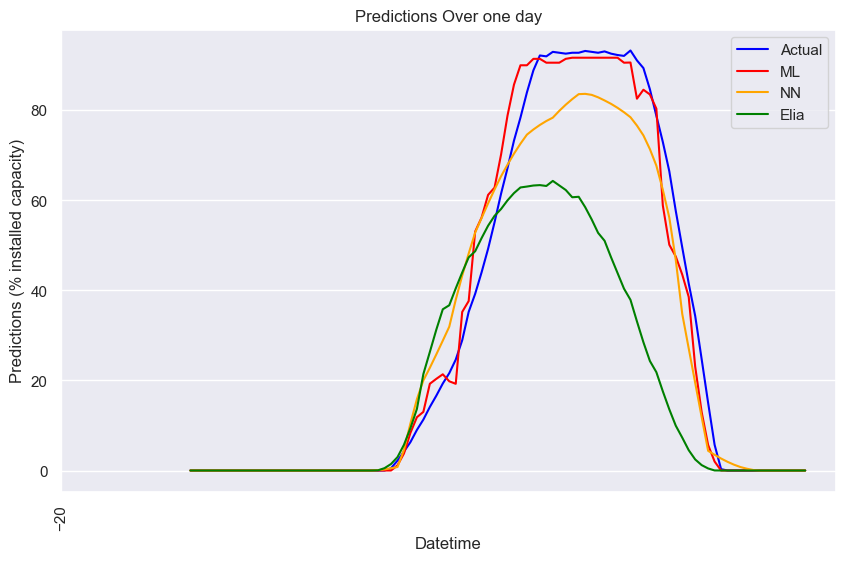

In [89]:
# Zet de voorspellingen uit van 1 dag
df_result_day = df_result.head(96)
plt.figure(figsize=(10, 6))
plt.plot(df_result_day['production_15_min_%'], label='Actual', color='blue')
plt.plot(df_result_day['predicted_with_ML(%)'], label='ML', color='red')
plt.plot(df_result_day['predicted_with_NN(%)'], label='NN', color='orange')
#plt.plot(df_result_day['predicted_with_Prophet(%)'], label='Prophet', color='yellow')
plt.plot(df_result_day['predicted_with_Elia(%)'], label='Elia', color='green')
plt.xlabel('Datetime')
plt.ylabel('Predictions (% installed capacity)')
plt.title('Predictions Over one day')
plt.grid(True) 
x_ticks = plt.gca().get_xticks() 
x_ticks_selected = x_ticks[::24] 
plt.xticks(x_ticks_selected, rotation=90)
plt.legend()
plt.show()

#### Prophet:

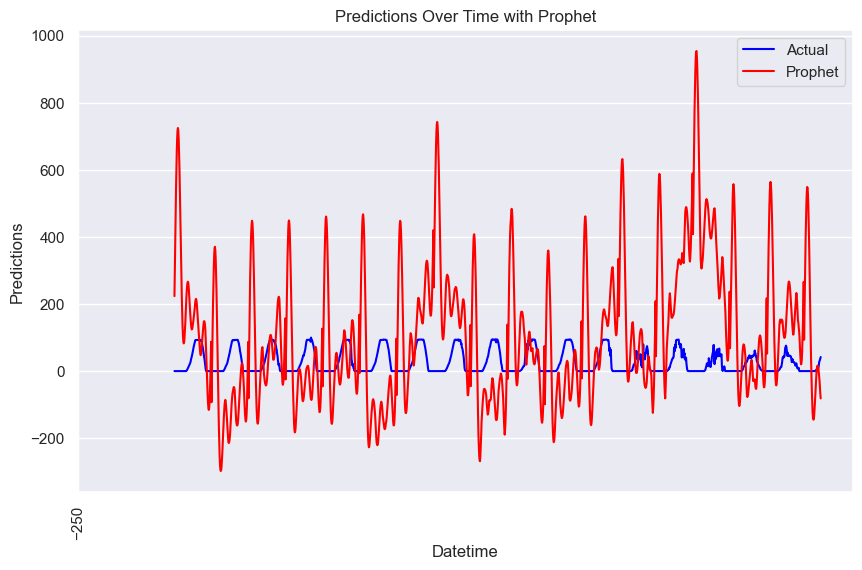

In [90]:
# Zet de voorspellingen uit in een grafiek
plt.figure(figsize=(10, 6))
plt.plot(df_result['production_15_min_%'], label='Actual', color='blue')
plt.plot(df_result['predicted_with_Prophet(%)'], label='Prophet', color='red')
plt.xlabel('Datetime')
plt.ylabel('Predictions')
plt.title('Predictions Over Time with Prophet')
plt.grid(True) 
x_ticks = plt.gca().get_xticks() 
x_ticks_selected = x_ticks[::24] 
plt.xticks(x_ticks_selected, rotation=90)
plt.legend()
plt.show()

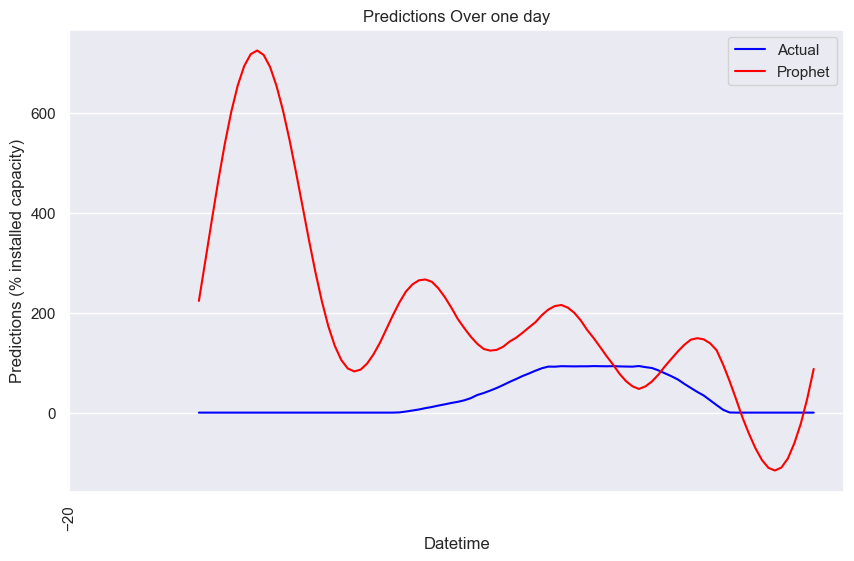

In [91]:
# Zet de voorspellingen uit van 1 dag
df_result_day = df_result.head(96)
plt.figure(figsize=(10, 6))
plt.plot(df_result_day['production_15_min_%'], label='Actual', color='blue')
plt.plot(df_result_day['predicted_with_Prophet(%)'], label='Prophet', color='red')
plt.xlabel('Datetime')
plt.ylabel('Predictions (% installed capacity)')
plt.title('Predictions Over one day')
plt.grid(True) 
x_ticks = plt.gca().get_xticks() 
x_ticks_selected = x_ticks[::24] 
plt.xticks(x_ticks_selected, rotation=90)
plt.legend()
plt.show()

#### LSTM 2h-ahead:

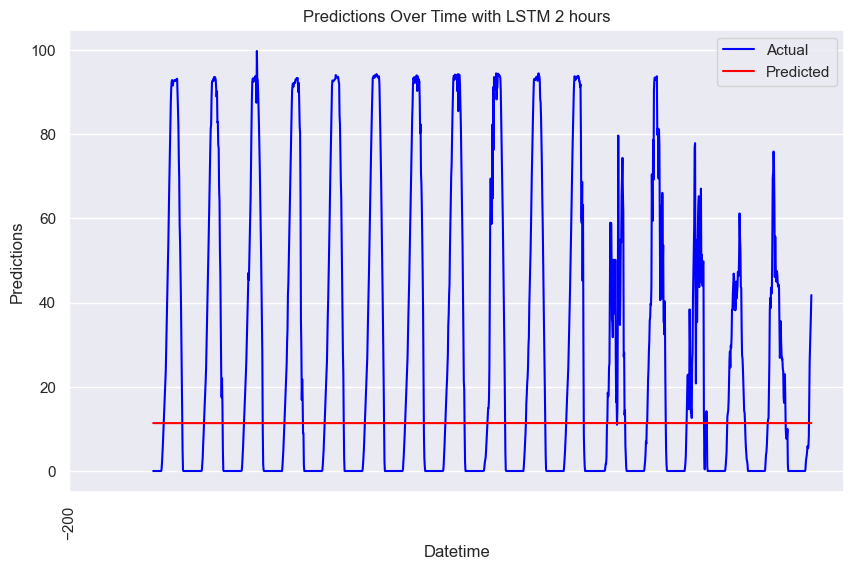

In [92]:
# Zet de voorspellingen uit in een grafiek LSTM 2h
plt.figure(figsize=(10, 6))
plt.plot(df_result_lstm_2_hour['production_15_min_%'], label='Actual', color='blue')
plt.plot(df_result_lstm_2_hour['predicted_with_LSTM_2_hour(%)'], label='Predicted', color='red')
plt.xlabel('Datetime')
plt.ylabel('Predictions')
plt.title('Predictions Over Time with LSTM 2 hours')
plt.grid(True)
x_ticks = plt.gca().get_xticks()
x_ticks_selected = x_ticks[::24]
plt.xticks(x_ticks_selected, rotation=90)
plt.legend()
plt.show()

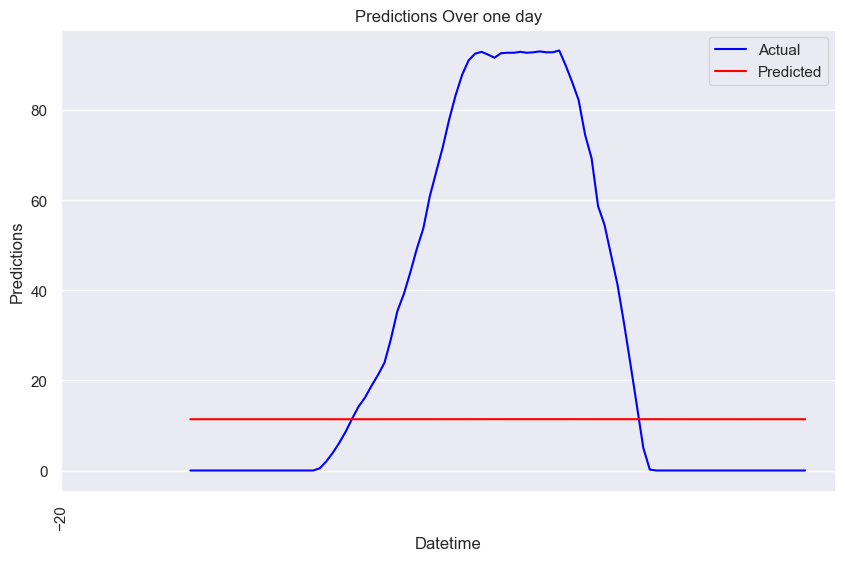

In [93]:
# Zet de voorspellingen uit in een grafiek LSTM 2h
df_result_lstm_2_hour_day = df_result_lstm_2_hour.head(96)
plt.figure(figsize=(10, 6))
plt.plot(df_result_lstm_2_hour_day['production_15_min_%'], label='Actual', color='blue')
plt.plot(df_result_lstm_2_hour_day['predicted_with_LSTM_2_hour(%)'], label='Predicted', color='red')
plt.xlabel('Datetime')
plt.ylabel('Predictions')
plt.title('Predictions Over one day')
plt.grid(True)
x_ticks = plt.gca().get_xticks()
x_ticks_selected = x_ticks[::24]
plt.xticks(x_ticks_selected, rotation=90)
plt.legend()
plt.show()

#### LSTM 24h-ahead:

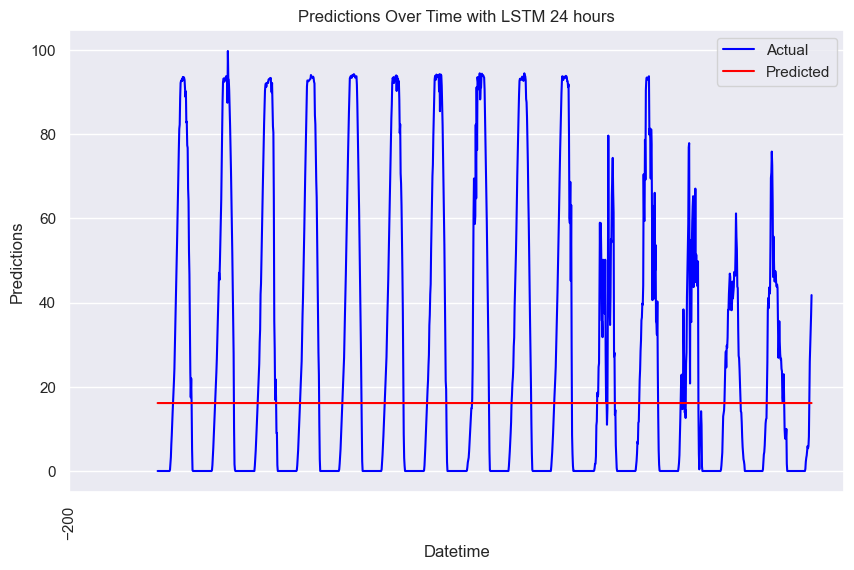

In [94]:
# Zet de voorspellingen uit in een grafiek LSTM 24h
plt.figure(figsize=(10, 6))
plt.plot(df_result_lstm_24_hour['production_15_min_%'], label='Actual', color='blue')
plt.plot(df_result_lstm_24_hour['predicted_with_LSTM_24_hour(%)'], label='Predicted', color='red')
plt.xlabel('Datetime')
plt.ylabel('Predictions')
plt.title('Predictions Over Time with LSTM 24 hours')
plt.grid(True)
x_ticks = plt.gca().get_xticks()
x_ticks_selected = x_ticks[::24]
plt.xticks(x_ticks_selected, rotation=90)
plt.legend()
plt.show()

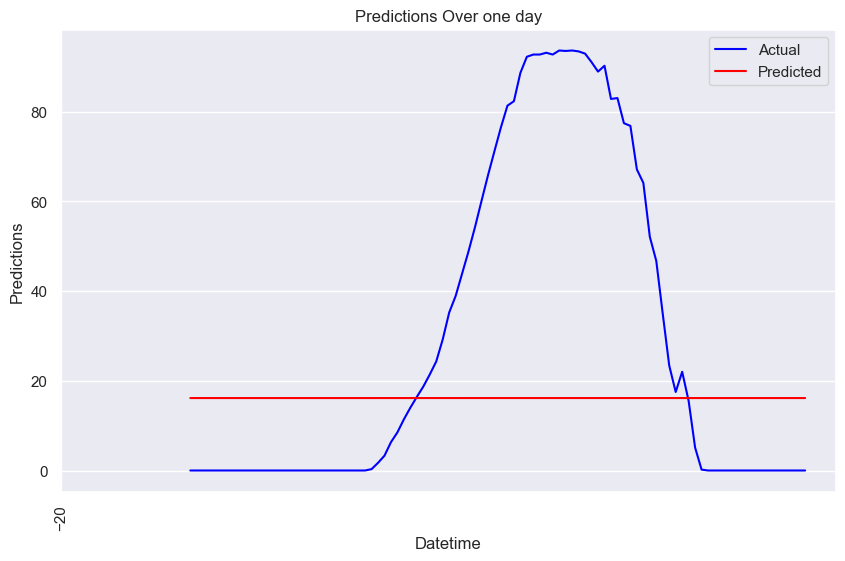

In [95]:
# Zet de voorspellingen uit in een grafiek LSTM 24h
df_result_lstm_24_hour_day = df_result_lstm_24_hour.head(96)
plt.figure(figsize=(10, 6))
plt.plot(df_result_lstm_24_hour_day['production_15_min_%'], label='Actual', color='blue')
plt.plot(df_result_lstm_24_hour_day['predicted_with_LSTM_24_hour(%)'], label='Predicted', color='red')
plt.xlabel('Datetime')
plt.ylabel('Predictions')
plt.title('Predictions Over one day')
plt.grid(True)
x_ticks = plt.gca().get_xticks()
x_ticks_selected = x_ticks[::24]
plt.xticks(x_ticks_selected, rotation=90)
plt.legend()
plt.show()

### Overzicht accuraatheid

In [96]:
# Berekening van de nauwkeurigheid van het ML-model op basis van de testgegevens
print("### ML-model ###")
print(f"mae: {mean_absolute_error(df_result['production_15_min_%'], df_result['predicted_with_ML(%)'])}")
print(f"mse: {mean_squared_error(df_result['production_15_min_%'], df_result['predicted_with_ML(%)'])}")
print(f"r2: {r2_score(df_result['production_15_min_%'], df_result['predicted_with_ML(%)'])}")

### ML-model ###
mae: 4.835401564908743
mse: 89.75884735618347
r2: 0.924166065737847


In [97]:
# Berekening van de nauwkeurigheid van het NN-model op basis van de testgegevens
print("### NN-model ###")
print(f"mae: {mean_absolute_error(df_result['production_15_min_%'], df_result['predicted_with_NN(%)'])}")
print(f"mse: {mean_squared_error(df_result['production_15_min_%'], df_result['predicted_with_NN(%)'])}")
print(f"r2: {r2_score(df_result['production_15_min_%'], df_result['predicted_with_NN(%)'])}")

### NN-model ###
mae: 5.441167761418337
mse: 88.32601060834148
r2: 0.9253766165742795


In [98]:
# Berekening van de nauwkeurigheid van het Prophet-model op basis van de testgegevens
print("### Prophet-model ###")
print(f"mae: {mean_absolute_error(df_result['production_15_min_%'], df_result['predicted_with_Prophet(%)'])}")
print(f"mse: {mean_squared_error(df_result['production_15_min_%'], df_result['predicted_with_Prophet(%)'])}")
print(f"r2: {r2_score(df_result['production_15_min_%'], df_result['predicted_with_Prophet(%)'])}")

### Prophet-model ###
mae: 168.44913983533473
mse: 52898.2017950221
r2: -43.691736532571014


In [99]:
# Berekening van de nauwkeurigheid van het ELIA-model op basis van de testgegevens
print("### Elia-model ###")
print(f"mae: {mean_absolute_error(df_result['production_15_min_%'], df_result['predicted_with_Elia(%)'])}")
print(f"mse: {mean_squared_error(df_result['production_15_min_%'], df_result['predicted_with_Elia(%)'])}")
print(f"r2: {r2_score(df_result['production_15_min_%'], df_result['predicted_with_Elia(%)'])}")

### Elia-model ###
mae: 11.616087655682678
mse: 402.98726056659166
r2: 0.6595309506925531


In [100]:
# Berekening van de nauwkeurigheid van het LSTM 2h-ahead op basis van de testgegevens
print("### LSTM-model 2 hours ###")
print(f"mae: {mean_absolute_error(df_result_lstm_2_hour['production_15_min_%'], df_result_lstm_2_hour['predicted_with_LSTM_2_hour(%)'])}")
print(f"mse: {mean_squared_error(df_result_lstm_2_hour['production_15_min_%'], df_result_lstm_2_hour['predicted_with_LSTM_2_hour(%)'])}")
print(f"r2: {r2_score(df_result_lstm_2_hour['production_15_min_%'], df_result_lstm_2_hour['predicted_with_LSTM_2_hour(%)'])}")

### LSTM-model 2 hours ###
mae: 26.781189903687185
mse: 1403.2940393163817
r2: -0.19740413204461982


In [101]:
# Berekening van de nauwkeurigheid van het LSTM 24h-ahead op basis van de testgegevens
print("### LSTM-model 24 hours ###")
print(f"mae: {mean_absolute_error(df_result_lstm_24_hour['production_15_min_%'], df_result_lstm_24_hour['predicted_with_LSTM_24_hour(%)'])}")
print(f"mse: {mean_squared_error(df_result_lstm_24_hour['production_15_min_%'], df_result_lstm_24_hour['predicted_with_LSTM_24_hour(%)'])}")
print(f"r2: {r2_score(df_result_lstm_24_hour['production_15_min_%'], df_result_lstm_24_hour['predicted_with_LSTM_24_hour(%)'])}")

### LSTM-model 24 hours ###
mae: 27.108364410709484
mse: 1256.1622254516458
r2: -0.08798482809124564
